In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #visualisation
from geopy.geocoders import Nominatim
%matplotlib inline 
sns.set(color_codes=True)
import datetime
from datetime import date
from scipy import stats

import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pathlib
import mapclassify as mc
import contextily as cx

## 1.1 Cleaning messy outcome labels

In [2]:
cases_train = pd.read_csv('../data/cases_2021_train.csv')
cases_test = pd.read_csv('../data/cases_2021_test.csv')
location = pd.read_csv('../data/location_2021.csv')

In [3]:
cases_train.groupby('outcome').size()

outcome
Alive                               127
Dead                                  9
Death                                 4
Deceased                           3361
Died                                  4
Discharged                            2
Discharged from hospital              3
Hospitalized                     135524
Receiving Treatment                 183
Recovered                         62875
Stable                               24
Under treatment                     243
critical condition                    1
death                                29
died                                624
discharge                           114
discharged                           82
recovered                          2435
recovering at home 03.03.2020         2
released from quarantine              3
stable                              107
stable condition                     90
dtype: int64

In [4]:
cases_train.loc[cases_train.outcome == 'Discharged', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'Discharged from hospital', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'Hospitalized', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'critical condition', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'discharge', 'outcome_group'] = "hospitalized"
cases_train.loc[cases_train.outcome == 'discharged', 'outcome_group'] = "hospitalized"

cases_train.loc[cases_train.outcome == 'Alive', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'Receiving Treatment', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'Stable', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'Under treatment', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'recovering at home 03.03.2020', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'released from quarantine', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'stable', 'outcome_group'] = "nonhospitalized"
cases_train.loc[cases_train.outcome == 'stable condition', 'outcome_group'] = "nonhospitalized"

cases_train.loc[cases_train.outcome == 'Dead', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'Death', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'Deceased', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'Died', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'death', 'outcome_group'] = "deceased"
cases_train.loc[cases_train.outcome == 'died', 'outcome_group'] = "deceased"

cases_train.loc[cases_train.outcome == 'Recovered', 'outcome_group'] = "recovered"
cases_train.loc[cases_train.outcome == 'recovered', 'outcome_group'] = "recovered"

cases_train = cases_train.drop(columns=['outcome'])

In [5]:
cases_train.groupby('outcome_group').size()

outcome_group
deceased             4031
hospitalized       135726
nonhospitalized       779
recovered           65310
dtype: int64

## 1.2 Outcome labels
For the `cases_2021_train.csv` file, the type of data mining task is data cleaning, since the `outcome_group` labels are obtained by `.groupby()` method. The primary type is multi-class classification.

For the `cases_2021_test.csv` file, the type of data mining task is multi-class classification.

## 1.3 Exploratory Data Analysis (EDA)

In [6]:
cases_train

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome_group
0,NaN,NaN,Maharashtra,India,19.20000,72.96667,23.05.2020,NaN,NaN,False,hospitalized
1,NaN,NaN,Maharashtra,India,18.94017,72.83483,18.05.2020,NaN,https://t.me/indiacovid/5075,False,recovered
2,NaN,NaN,Maharashtra,India,19.20000,72.96667,28.05.2020,NaN,https://phdmah.maps.arcgis.com/apps/opsdashboa...,False,hospitalized
3,NaN,NaN,West Bengal,India,22.80862,88.79242,09.05.2020,NaN,https://www.wbhealth.gov.in/uploaded_files/cor...,False,hospitalized
4,NaN,NaN,Maharashtra,India,18.94017,72.83483,17.05.2020,NaN,NaN,False,hospitalized
...,...,...,...,...,...,...,...,...,...,...,...
205841,NaN,NaN,Maharashtra,India,16.70446,74.24137,21.05.2020,NaN,NaN,False,hospitalized
205842,NaN,NaN,Telangana,India,17.39487,78.47076,26.04.2020,NaN,https://twitter.com/Eatala_Rajender/status/125...,False,hospitalized
205843,NaN,NaN,Maharashtra,India,19.20000,72.96667,22.05.2020,NaN,NaN,False,recovered
205844,NaN,NaN,Maharashtra,India,18.94017,72.83483,24.05.2020,NaN,https://t.me/Allindiacovid/3814,False,hospitalized


In [7]:
cases_train.isnull().sum(axis = 0)

age                       182793
sex                       180362
province                     604
country                        1
latitude                       0
longitude                      0
date_confirmation             51
additional_information    193444
source                     18394
chronic_disease_binary         0
outcome_group                  0
dtype: int64

In [8]:
cases_test

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome_group
0,NaN,NaN,Maharashtra,India,18.940170,72.834830,08.04.2020,NaN,https://twitter.com/ANI/status/124776368418667...,False,NaN
1,NaN,NaN,Tamil Nadu,India,13.124620,79.918150,19.05.2020,NaN,https://stopcorona.tn.gov.in/wp-content/upload...,False,NaN
2,NaN,NaN,Maharashtra,India,18.940170,72.834830,14.05.2020,NaN,https://t.me/indiacovid/4755,False,NaN
3,23,female,Karnataka,India,12.527350,76.894650,23.05.2020,Returnees for Maharashtra,https://twitter.com/DHFWKA/status/126411013913...,False,NaN
4,NaN,NaN,Punjab,India,31.110475,76.154763,16.05.2020,NaN,https://twitter.com/kbssidhu1961/status/126163...,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
101382,NaN,NaN,Maharashtra,India,19.036810,73.015820,23.04.2020,NaN,https://twitter.com/ANI/status/125334219922530...,False,NaN
101383,NaN,NaN,Tamil Nadu,India,11.745140,79.758920,18.05.2020,NaN,https://stopcorona.tn.gov.in/wp-content/upload...,False,NaN
101384,NaN,NaN,Rajasthan,India,24.587000,73.698480,08.05.2020,NaN,https://twitter.com/ANI/status/125878720879583...,False,NaN
101385,NaN,NaN,Karnataka,India,16.166230,75.654150,18.05.2020,NaN,https://t.me/Karnataka_KoViD19_Broadcast/3350,False,NaN


In [9]:
cases_test.isnull().sum(axis = 0)

age                        90013
sex                        88765
province                     296
country                        1
latitude                       0
longitude                      0
date_confirmation             23
additional_information     95206
source                      9160
chronic_disease_binary         0
outcome_group             101387
dtype: int64

In [10]:
location

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,Afghanistan,2021-04-01 04:27:05,33.93911,67.709953,56454,2484,51550.0,2420.0,Afghanistan,145.020308,4.400043
1,NaN,Albania,2021-04-01 04:27:05,41.15330,20.168300,125157,2235,91271.0,31651.0,Albania,4349.051359,1.785757
2,NaN,Algeria,2021-04-01 04:27:05,28.03390,1.659600,117192,3093,81538.0,32561.0,Algeria,267.250200,2.639259
3,NaN,Andorra,2021-04-01 04:27:05,42.50630,1.521800,12010,115,11315.0,580.0,Andorra,15543.907332,0.957535
4,NaN,Angola,2021-04-01 04:27:05,-11.20270,17.873900,22311,537,20493.0,1281.0,Angola,67.884191,2.406884
...,...,...,...,...,...,...,...,...,...,...,...,...
3999,W.P. Kuala Lumpur,Malaysia,2021-04-01 04:27:05,3.13900,101.686900,37819,118,36631.0,1070.0,"W.P. Kuala Lumpur, Malaysia",2126.574449,0.312012
4000,W.P. Labuan,Malaysia,2021-04-01 04:27:05,5.28310,115.230800,2327,12,2282.0,33.0,"W.P. Labuan, Malaysia",2341.046278,0.515685
4001,W.P. Putrajaya,Malaysia,2021-04-01 04:27:05,2.92640,101.696400,1142,8,1102.0,32.0,"W.P. Putrajaya, Malaysia",1083.491461,0.700525
4002,Unknown,Malaysia,2021-04-01 04:27:05,NaN,NaN,0,0,0.0,0.0,"Unknown, Malaysia",NaN,NaN


In [11]:
location.isnull().sum(axis = 0)

Province_State          174
Country_Region            0
Last_Update               0
Lat                      89
Long_                    89
Confirmed                 0
Deaths                    0
Recovered              3275
Active                 3275
Combined_Key              0
Incident_Rate            90
Case_Fatality_Ratio      48
dtype: int64

To draw historgram of age value, we decide to perform data cleaning of age in this section.

In [12]:
cases_train = cases_train[cases_train['age'].notna()]
cases_test = cases_test[cases_test['age'].notna()]

In [13]:
# Function that handle age column.
def handleAge(age):
    if ' months' in age:
        return round(float(age.replace(' months', ''))/12)
    positionOfTo = age.find('-')
    if positionOfTo >= 1:
        age1 = float(age[0:positionOfTo])
        age2 = age[positionOfTo+1:]
        if len(age2) <= 0:
            age2 = 0
        else:
            age2 = float(age2)
        age = (age1 + age2) / 2
    return(round(float(age)))

In [14]:
cases_train['age'] = cases_train['age'].apply(handleAge)
cases_test['age'] = cases_test['age'].apply(handleAge)

/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Count')

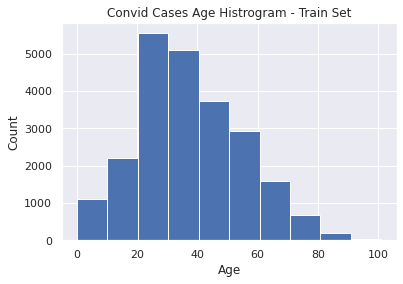

In [15]:
# historgram of training data's age
ax = cases_train['age'].hist()
ax.set_title('Convid Cases Age Histrogram - Train Set')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

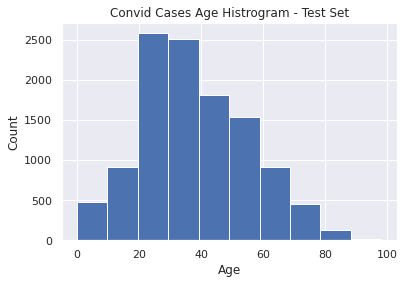

In [16]:
# historgram of testing data's age
ax = cases_test['age'].hist()
ax.set_title('Convid Cases Age Histrogram - Test Set')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

Text(0.5, 1.0, 'Covid Cases in Sex Group - Train Set')

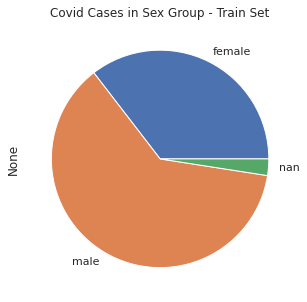

In [17]:
ax = cases_train.groupby('sex',dropna=False).size().plot.pie(y='sex', figsize=(5, 5))
ax.set_title('Covid Cases in Sex Group - Train Set')

Text(0.5, 1.0, 'Covid Cases in Sex Group - Test Set')

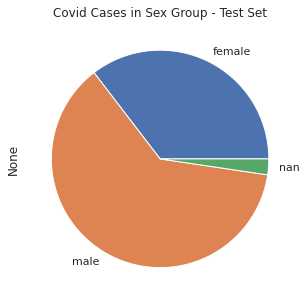

In [18]:
ax = cases_test.groupby('sex',dropna=False).size().plot.pie(y='sex', figsize=(5, 5))
ax.set_title('Covid Cases in Sex Group - Test Set')

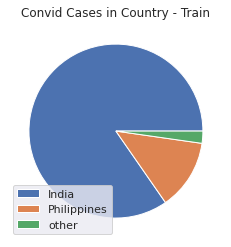

In [19]:
# cases_train.groupby('country',dropna=False).size().sort_values().plot.pie(y='country')
cases_train_groupby_country = cases_train.groupby('country',dropna=False).size().sort_values(ascending=False)
cases_train_groupby_country_valueArray = cases_train_groupby_country.values
cases_train_groupby_country_countryArray = cases_train_groupby_country.index.tolist()

first2Value = cases_train_groupby_country_valueArray[0:2]
restValue = np.sum(cases_train_groupby_country_valueArray[2:])

cases_train_groupby_country_valueArray = np.append(first2Value, restValue)
cases_train_groupby_country_countryArray = np.append(cases_train_groupby_country_countryArray[0:2], 'other')

plt.pie(cases_train_groupby_country_valueArray)
plt.legend(loc=3, labels=cases_train_groupby_country_countryArray)
plt.title('Convid Cases in Country - Train')
plt.show() 

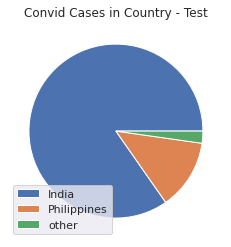

In [20]:
# cases_train.groupby('country',dropna=False).size().sort_values().plot.pie(y='country')
cases_test_groupby_country = cases_test.groupby('country',dropna=False).size().sort_values(ascending=False)
cases_test_groupby_country_valueArray = cases_test_groupby_country.values
cases_test_groupby_country_countryArray = cases_test_groupby_country.index.tolist()

first2Value = cases_test_groupby_country_valueArray[0:2]
restValue = np.sum(cases_test_groupby_country_valueArray[2:])

cases_test_groupby_country_valueArray = np.append(first2Value, restValue)
cases_test_groupby_country_countryArray = np.append(cases_test_groupby_country_countryArray[0:2], 'other')

plt.pie(cases_test_groupby_country_valueArray)
plt.legend(loc=3, labels=cases_test_groupby_country_countryArray)
plt.title('Convid Cases in Country - Test')
plt.show() 

Text(0, 0.5, 'Count')

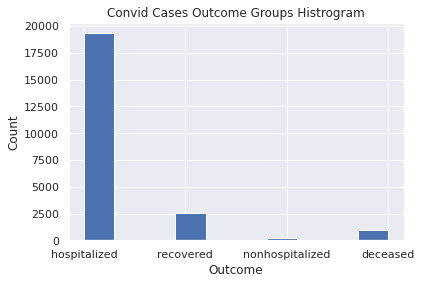

In [21]:
ax = cases_train['outcome_group'].hist()
ax.set_title('Convid Cases Outcome Groups Histrogram')
ax.set_xlabel('Outcome')
ax.set_ylabel('Count')

In [22]:
location['Confirmed_log'] = np.log(location['Confirmed'] + 1)
location['Deaths_log'] = np.log(location['Deaths'] + 1)
location['Active_log'] = np.log(location['Active'] + 1)
location['Recovered_log'] = np.log(location['Recovered'] + 1)

Text(0, 0.5, 'Count')

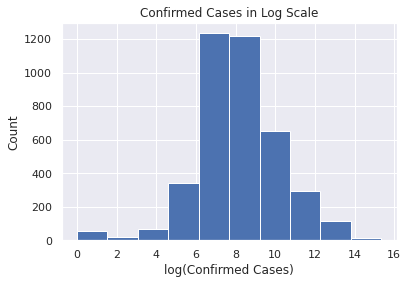

In [23]:
ax = location['Confirmed_log'].hist()
ax.set_title('Confirmed Cases in Log Scale')
ax.set_xlabel('log(Confirmed Cases)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

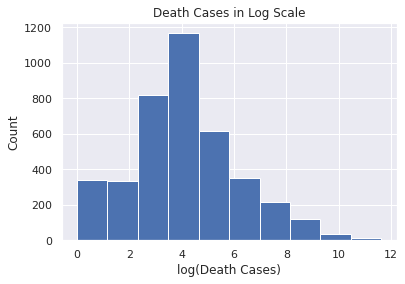

In [24]:
ax = location['Deaths_log'].hist()
ax.set_title('Death Cases in Log Scale')
ax.set_xlabel('log(Death Cases)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

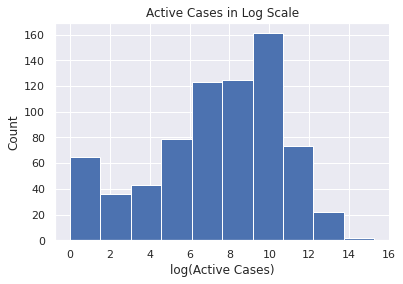

In [25]:
ax = location['Active_log'].hist()
ax.set_title('Active Cases in Log Scale')
ax.set_xlabel('log(Active Cases)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

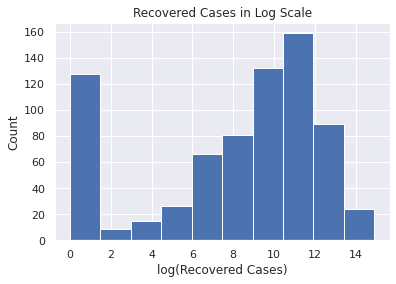

In [26]:
ax = location['Recovered_log'].hist()
ax.set_title('Recovered Cases in Log Scale')
ax.set_xlabel('log(Recovered Cases)')
ax.set_ylabel('Count')

<AxesSubplot:title={'center':'Top 10 Countries with the Most Confirmed Cases'}, ylabel='Country'>

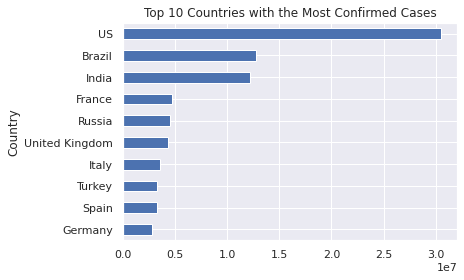

In [27]:
# Confirmed	Deaths	Recovered	Active	Incident_Rate	Case_Fatality_Ratio
loc_contry_grp = location.groupby('Country_Region')
country_cf = loc_contry_grp.sum('Confirmed').sort_values(by='Confirmed', ascending=False).head(10)
country_cf['Confirmed'].sort_values(ascending=True).plot.barh(title='Top 10 Countries with the Most Confirmed Cases', xlabel='Country')

<AxesSubplot:title={'center':'Top 10 Countries with the Most Death Cases'}, ylabel='Country'>

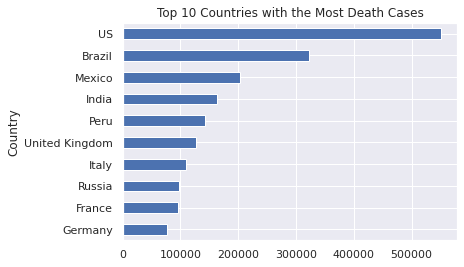

In [28]:
country_d = loc_contry_grp.sum('Deaths').sort_values(by='Deaths', ascending=False).head(10)
country_d['Deaths'].sort_values(ascending=True).plot.barh(title='Top 10 Countries with the Most Death Cases', xlabel='Country')

<AxesSubplot:title={'center':'Top 10 Countries with the Most Active Cases'}, ylabel='Country'>

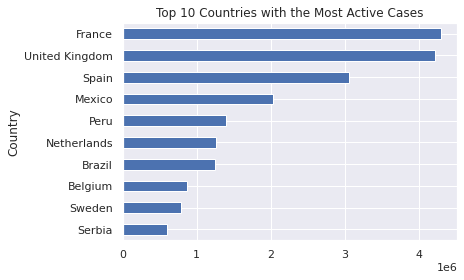

In [29]:
country_a = loc_contry_grp.sum('Active').sort_values(by='Active', ascending=False).head(10)
country_a['Active'].sort_values(ascending=True).plot.barh(title='Top 10 Countries with the Most Active Cases', xlabel='Country')

<AxesSubplot:title={'center':'Top 10 Countries with the Most Recovered Cases'}, ylabel='Country'>

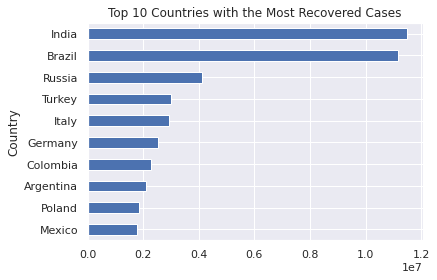

In [30]:
country_r = loc_contry_grp.sum('Recovered').sort_values(by='Recovered', ascending=False).head(10)
country_r['Recovered'].sort_values(ascending=True).plot.barh(title='Top 10 Countries with the Most Recovered Cases', xlabel='Country')

<AxesSubplot:title={'center':'Top 10 Countries with the Most Incident Rate'}, ylabel='Country'>

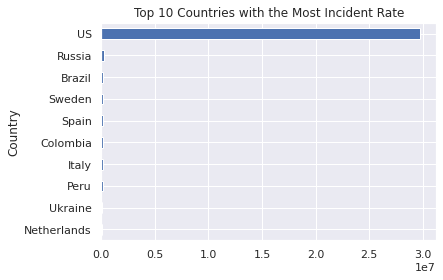

In [31]:
country_i = loc_contry_grp.sum('Incident_Rate').sort_values(by='Incident_Rate', ascending=False).head(10)
country_i['Incident_Rate'].sort_values(ascending=True).plot.barh(title='Top 10 Countries with the Most Incident Rate', xlabel='Country')

<AxesSubplot:title={'center':'Top 10 Countries with the Most Case Fatality Ratio'}, ylabel='Country'>

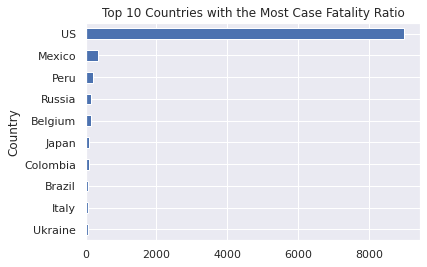

In [32]:
country_f = loc_contry_grp.sum('Case_Fatality_Ratio').sort_values(by='Case_Fatality_Ratio', ascending=False).head(10)
country_f['Case_Fatality_Ratio'].sort_values(ascending=True).plot.barh(title='Top 10 Countries with the Most Case Fatality Ratio', xlabel='Country')

In [33]:
location_na = location.dropna(subset=['Lat', 'Long_'])
location_g = gpd.GeoDataFrame(location_na, geometry=gpd.points_from_xy(x=location_na.Long_, y=location_na.Lat))
location_g

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Confirmed_log,Deaths_log,Active_log,Recovered_log,geometry
0,NaN,Afghanistan,2021-04-01 04:27:05,33.93911,67.709953,56454,2484,51550.0,2420.0,Afghanistan,145.020308,4.400043,10.941199,7.818028,7.791936,10.850327,POINT (67.70995 33.93911)
1,NaN,Albania,2021-04-01 04:27:05,41.15330,20.168300,125157,2235,91271.0,31651.0,Albania,4349.051359,1.785757,11.737332,7.712444,10.362557,11.421599,POINT (20.16830 41.15330)
2,NaN,Algeria,2021-04-01 04:27:05,28.03390,1.659600,117192,3093,81538.0,32561.0,Algeria,267.250200,2.639259,11.671577,8.037220,10.390901,11.308837,POINT (1.65960 28.03390)
3,NaN,Andorra,2021-04-01 04:27:05,42.50630,1.521800,12010,115,11315.0,580.0,Andorra,15543.907332,0.957535,9.393578,4.753590,6.364751,9.333973,POINT (1.52180 42.50630)
4,NaN,Angola,2021-04-01 04:27:05,-11.20270,17.873900,22311,537,20493.0,1281.0,Angola,67.884191,2.406884,10.012880,6.287859,7.156177,9.927887,POINT (17.87390 -11.20270)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,Terengganu,Malaysia,2021-04-01 04:27:05,5.31170,103.132400,3595,13,3547.0,35.0,"Terengganu, Malaysia",287.576994,0.361613,8.187577,2.639057,3.583519,8.174139,POINT (103.13240 5.31170)
3999,W.P. Kuala Lumpur,Malaysia,2021-04-01 04:27:05,3.13900,101.686900,37819,118,36631.0,1070.0,"W.P. Kuala Lumpur, Malaysia",2126.574449,0.312012,10.540593,4.779123,6.976348,10.508677,POINT (101.68690 3.13900)
4000,W.P. Labuan,Malaysia,2021-04-01 04:27:05,5.28310,115.230800,2327,12,2282.0,33.0,"W.P. Labuan, Malaysia",2341.046278,0.515685,7.752765,2.564949,3.526361,7.733246,POINT (115.23080 5.28310)
4001,W.P. Putrajaya,Malaysia,2021-04-01 04:27:05,2.92640,101.696400,1142,8,1102.0,32.0,"W.P. Putrajaya, Malaysia",1083.491461,0.700525,7.041412,2.197225,3.496508,7.005789,POINT (101.69640 2.92640)


Text(0.5, 1.0, 'Confirmed Cases World Map in Log Scale')

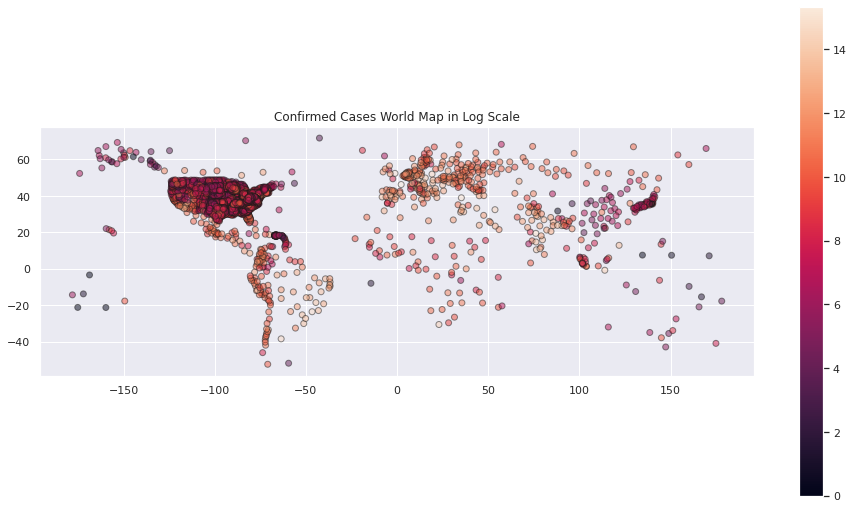

In [34]:
ax = location_g.plot(figsize=(16, 9),
    alpha=0.5,
    edgecolor='k',
    column='Confirmed_log',
    legend=True)

ax.set_title('Confirmed Cases World Map in Log Scale')

Text(0.5, 1.0, 'Active Cases World Map in Log Scale')

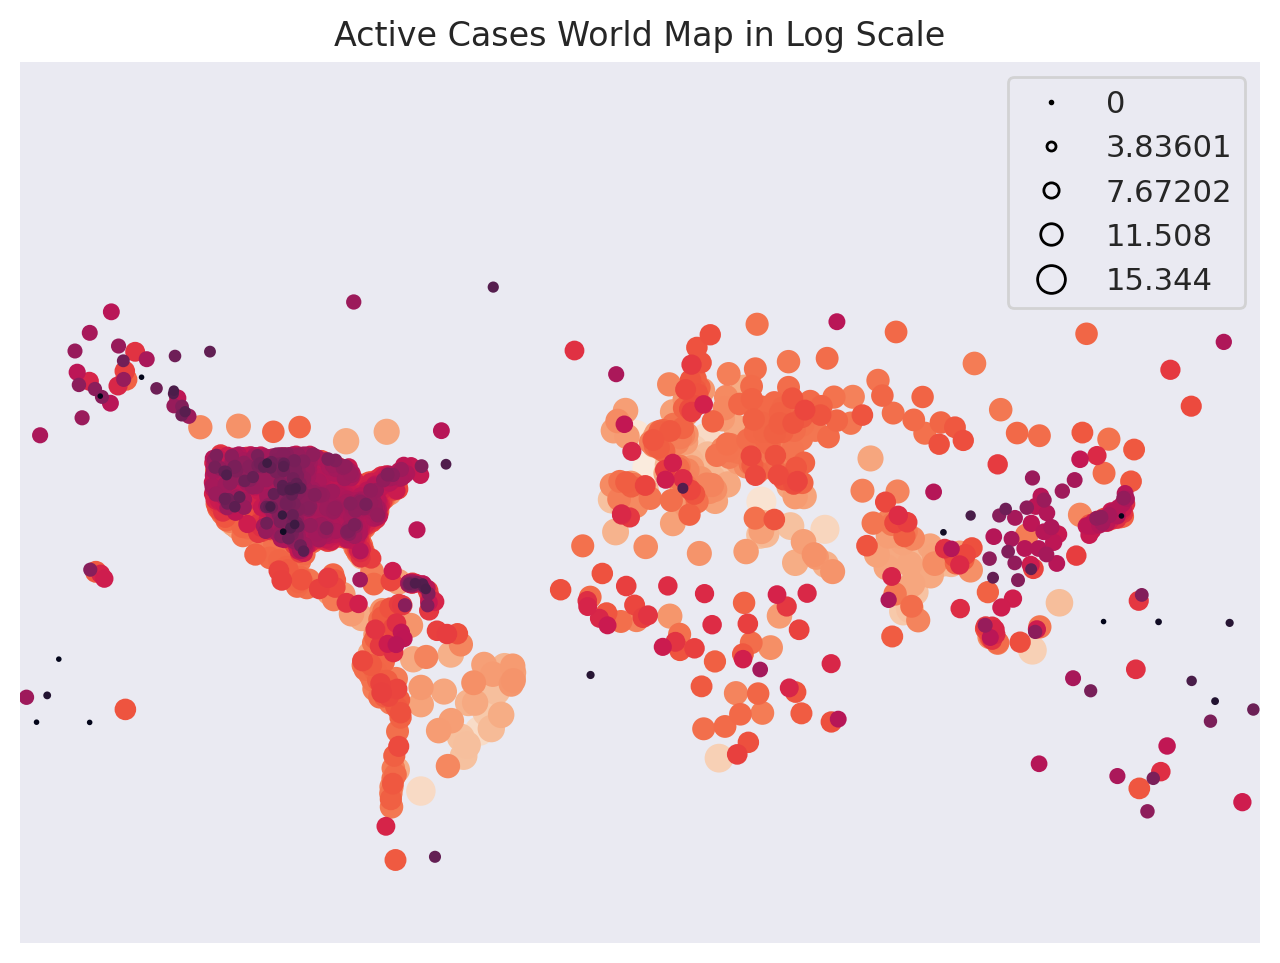

In [35]:
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

ax = gplt.pointplot(
    location_g, projection=gcrs.WebMercator(),
    hue='Confirmed_log', scale='Confirmed_log', limits=(1, 10),
    legend=True, legend_var='scale'
)
ax.set_title('Confirmed Cases World Map in Log Scale')

## 1.4 Data cleaning and imputing missing values

In [36]:
# Codes that used to check which columns contain NaN
nan_values = cases_train.isna()
nan_columns = nan_values.any()
columns_with_nan = cases_train.columns[nan_columns].tolist()
print(columns_with_nan)

['sex', 'province', 'country', 'date_confirmation', 'additional_information', 'source']


In [37]:
# Codes that used to check which columns contain NaN
nan_values = cases_test.isna()
nan_columns = nan_values.any()
columns_with_nan = cases_test.columns[nan_columns].tolist()
print(columns_with_nan)

['sex', 'province', 'country', 'date_confirmation', 'additional_information', 'source', 'outcome_group']


In [38]:
# Replace NaN in sex column by 'unknown'
cases_train['sex'] = cases_train['sex'].replace(np.nan, 'unknown')
cases_test['sex'] = cases_test['sex'].replace(np.nan, 'unknown')

/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# With lait land long, we can use geopy to find the country and provience name.
def handleCountry(lait,long, country):
    if pd.notna(country):
        return country
    else:
        if lait > 90 or lait < -90 or long > 180 or long < -180:
            return country
        geolocator = Nominatim(user_agent="geoapiExercises")
        loc = geolocator.reverse(str(lait)+','+str(long), language='en', timeout=None)
        if loc is None:
            return country
        address = loc.raw['address']
        Country = address.get('country', '')
        return Country
def handleProvince(long, lait, province):
    if pd.notna(province):
        return province
    else:
        if lait > 90 or lait < -90 or long > 180 or long < -180:
            return province
        geolocator = Nominatim(user_agent="geoapiExercises")
        loc = geolocator.reverse(str(lait)+","+str(long), language='en', timeout=None)
        if loc is None:
            return province
        address = loc.raw['address']
        Province = address.get('state', '')
        return Province

To handle GeocoderServiceError:

Download https://letsencrypt.org/certs/lets-encrypt-r3.pem

rename file .pem to .cer

install

In [40]:
try:
    cases_train['country'] = cases_train.apply(lambda row : handleCountry(row['latitude'], row['longitude'], row['country']), axis = 1)
    cases_train['province'] = cases_train.apply(lambda row: handleProvince(row['latitude'], row['longitude'], row['province']), axis = 1)
    cases_test['country'] = cases_test.apply(lambda row : handleCountry(row['latitude'], row['longitude'], row['country']), axis = 1)
    cases_test['province'] = cases_test.apply(lambda row: handleProvince(row['latitude'], row['longitude'], row['province']), axis = 1)
except:
    print("Unable to reach geopy server, just remove rows with NaN in country and provience instead.")


# For rows still have country or province as NaN, replace NaN with 'unknown'
cases_train[['country', 'province']] = cases_train[['country','province']].fillna(value='unknown')
cases_test[['country', 'province']] = cases_test[['country','province']].fillna(value='unknown')


/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [41]:
allDate = cases_train['date_confirmation'].dropna().tolist() + cases_test['date_confirmation'].dropna().tolist()

In [42]:
# Use the average date to replace NaN
# May cause dataset skewed
totalDays = 0
initialDay = date(1, 1, 1)
for i in allDate:
    day = int(i[0:2])
    month = int(i[3:5])
    year = int(i[6:10])
    currDate = date(year, month, day)
    totalDays = totalDays + (currDate - initialDay).days
avgDays = round(totalDays/len(allDate))
avgDate = initialDay + datetime.timedelta(days = avgDays)
avgDateInStr = str(avgDate.day) + '.' + str(avgDate.month) + '.' + str(avgDate.year)
cases_train['date_confirmation'] = cases_train['date_confirmation'].fillna(avgDateInStr)
cases_test['date_confirmation'] = cases_test['date_confirmation'].fillna(avgDateInStr)

/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [43]:
# Replace NaN in additional_information and source with empty string
cases_train['additional_information'] = cases_train['additional_information'].fillna('')
cases_test['additional_information'] = cases_test['additional_information'].fillna('')
cases_train['source'] = cases_train['source'].fillna('')
cases_test['source'] = cases_test['source'].fillna('')

/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yunlongl/anaconda3/envs/cmpt459/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [44]:
# Remove rows with NaN in Lat and Long_
location = location[location['Lat'].notna()]
location = location[location['Long_'].notna()]

In [45]:
# Geopy can not really help find the province state with lait and long
# Replace NaN in Province_State with unknown
# location['Province_State'] = location.apply(lambda row: handleProvince(row['Lat'], row['Long_'], row['Province_State']), axis = 1)
location['Province_State'] = location['Province_State'].fillna('Unknown')

In [46]:
# Use average recover ratio to calculate number of recovered and active
# MAY CAUSE DATASET SKEWED
def handleRecovered(Confirmed, Deaths, Recovered, Active, MeanRecoverRatio):
    if pd.notna(Recovered):
        return Recovered
    else:
        if pd.notna(Active):
            return (Confirmed-Deaths)-Active
        else:
            return (Confirmed-Deaths)*MeanRecoverRatio
        return Country
def handleActive(Confirmed, Deaths, Recovered, Active, MeanRecoverRatio):
    if pd.notna(Active):
        return Active
    else:
        if pd.notna(Recovered):
            return (Confirmed-Deaths)-Recovered
        else:
            return (Confirmed-Deaths)*(1-MeanRecoverRatio)
        return Country

In [47]:
recoveredAndActive = location.get(['Recovered','Active'])
recoveredAndActive = recoveredAndActive[recoveredAndActive['Recovered'].notna()]
recoveredAndActive = recoveredAndActive[recoveredAndActive['Active'].notna()]
recoveredAndActive['RecoverRatio'] = recoveredAndActive['Recovered']/(recoveredAndActive['Recovered']+recoveredAndActive['Active'])
MeanRecoverRatio = recoveredAndActive['RecoverRatio'].mean()


location['Recovered'] = location.apply(lambda row: handleRecovered(row['Confirmed'], row['Deaths'], row['Recovered'], row['Active'],MeanRecoverRatio), axis = 1)
location['Active'] = location.apply(lambda row: handleActive(row['Confirmed'], row['Deaths'], row['Recovered'], row['Active'],MeanRecoverRatio), axis = 1)

location['Case_Fatality_Ratio'] = location['Case_Fatality_Ratio'].fillna(0)
location['Incident_Rate'] = location['Incident_Rate'].fillna(0)

In [48]:
nan_values = location.isna()
nan_columns = nan_values.any()
columns_with_nan = location.columns[nan_columns].tolist()
print(columns_with_nan)

['Active_log', 'Recovered_log']


## 1.5 Dealing with outliers

In previous steps, we have dropped rows in cases_train, cases_test and location with wrong latitude and longitude. Thus, we do not have to handle outlaiers in latitude and longitude. 
Moreover, by checking the box plot of age, we can say that the age values are reasonable. Age in train and test sets does not include particularly unreasonable values.

However, by checking the box plots, we can see there are significent outliers in 'Confirmed', 'Recovered', 'Active'

In [49]:
cases_train.select_dtypes(include=np.number)

,age,latitude,longitude
5,40,13.08362,80.28252
43,37,12.68224,79.98008
46,40,8.96350,77.30821
48,27,13.08362,80.28252
52,54,10.38486,78.79294
...,...,...,...
205787,17,13.08362,80.28252
205789,25,25.73271,86.98845
205792,16,13.08362,80.28252
205810,52,12.68224,79.98008


In [50]:
cases_test.select_dtypes(include=np.number)

,age,latitude,longitude,outcome_group
3,23,12.52735,76.89465,NaN
13,18,25.23169,83.92138,NaN
14,26,17.33274,76.84035,NaN
16,21,13.08362,80.28252,NaN
18,32,13.08362,80.28252,NaN
...,...,...,...,...
101362,32,13.99363,74.55087,NaN
101366,33,13.08362,80.28252,NaN
101373,45,13.08362,80.28252,NaN
101377,18,26.49002,84.89589,NaN


In [51]:
location.select_dtypes(include=np.number)

,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Confirmed_log,Deaths_log,Active_log,Recovered_log
0,33.93911,67.709953,56454,2484,51550.0,2420.0,145.020308,4.400043,10.941199,7.818028,7.791936,10.850327
1,41.15330,20.168300,125157,2235,91271.0,31651.0,4349.051359,1.785757,11.737332,7.712444,10.362557,11.421599
2,28.03390,1.659600,117192,3093,81538.0,32561.0,267.250200,2.639259,11.671577,8.037220,10.390901,11.308837
3,42.50630,1.521800,12010,115,11315.0,580.0,15543.907332,0.957535,9.393578,4.753590,6.364751,9.333973
4,-11.20270,17.873900,22311,537,20493.0,1281.0,67.884191,2.406884,10.012880,6.287859,7.156177,9.927887
...,...,...,...,...,...,...,...,...,...,...,...,...
3998,5.31170,103.132400,3595,13,3547.0,35.0,287.576994,0.361613,8.187577,2.639057,3.583519,8.174139
3999,3.13900,101.686900,37819,118,36631.0,1070.0,2126.574449,0.312012,10.540593,4.779123,6.976348,10.508677
4000,5.28310,115.230800,2327,12,2282.0,33.0,2341.046278,0.515685,7.752765,2.564949,3.526361,7.733246
4001,2.92640,101.696400,1142,8,1102.0,32.0,1083.491461,0.700525,7.041412,2.197225,3.496508,7.005789


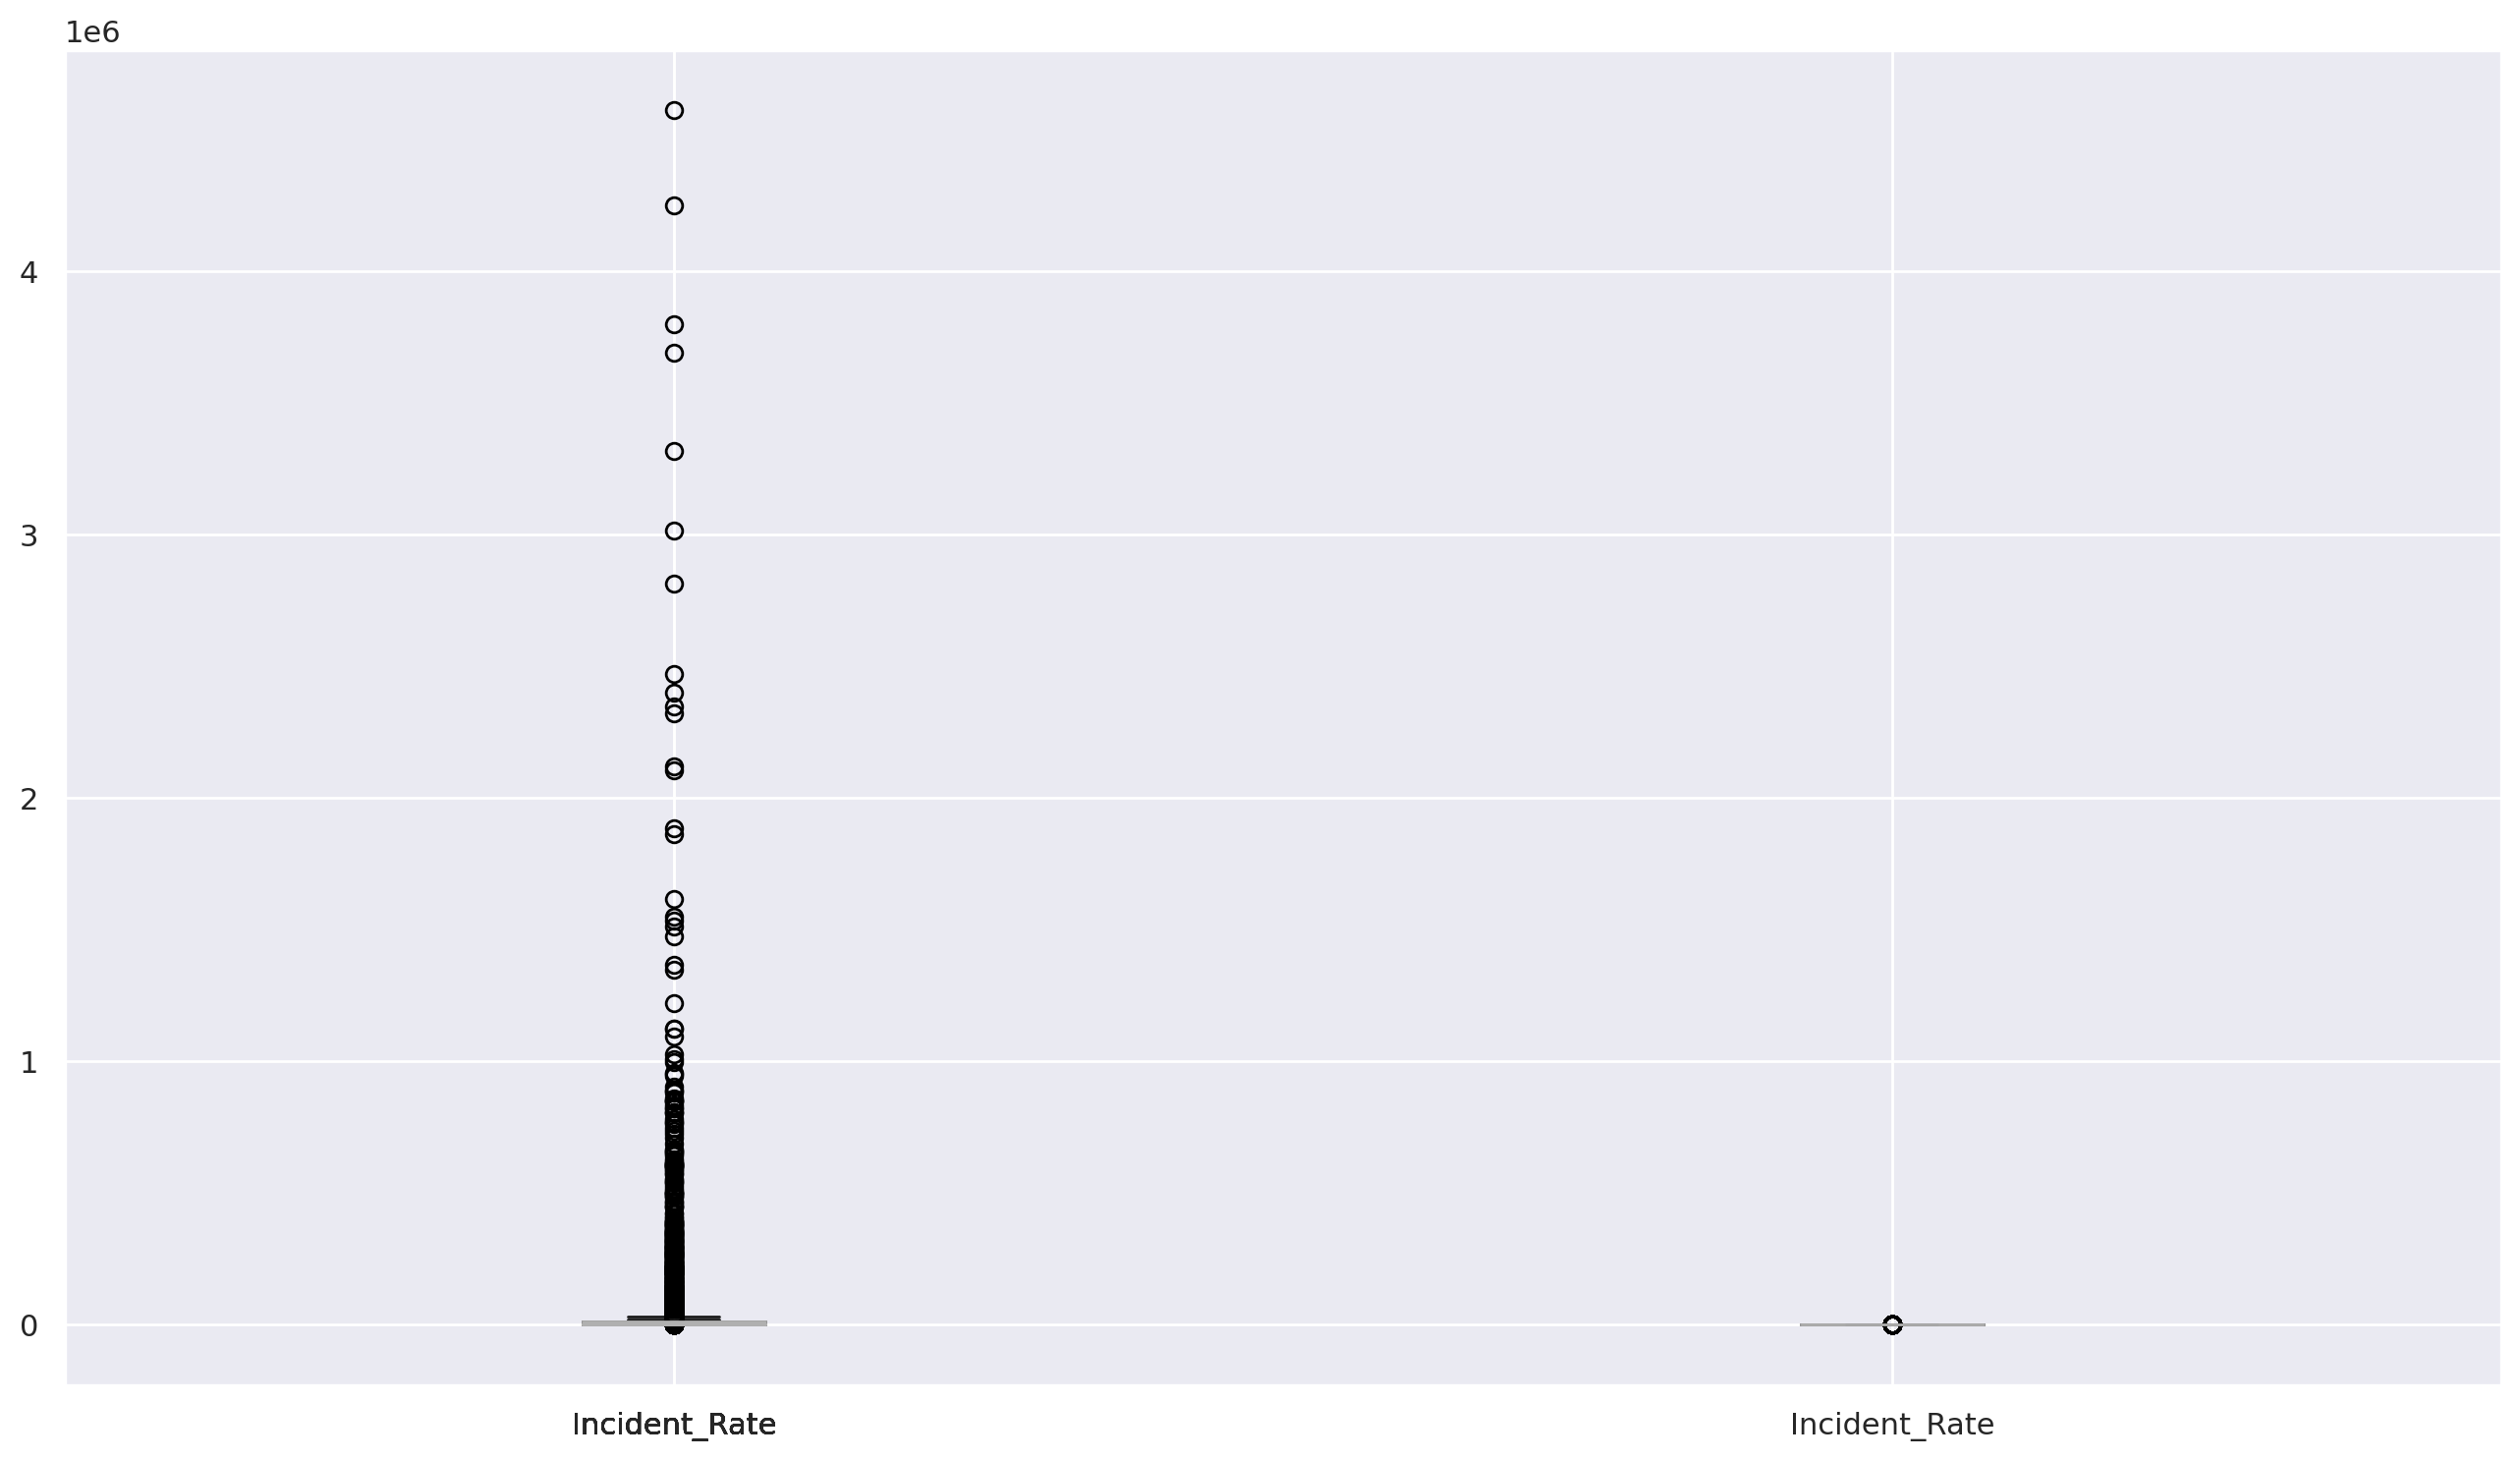

In [52]:
boxplot1 = cases_train.boxplot(column=['age'])
boxplot2 = cases_test.boxplot(column=['age'])
boxplot3 = location.boxplot(column=['Lat', 'Long_'])
boxplot4 = location.boxplot(column=['Confirmed'])
boxplot5 = location.boxplot(column=['Deaths'])
boxplot6 = location.boxplot(column=['Recovered'])
boxplot7 = location.boxplot(column=['Active'])
boxplot8 = location.boxplot(column=['Incident_Rate'])


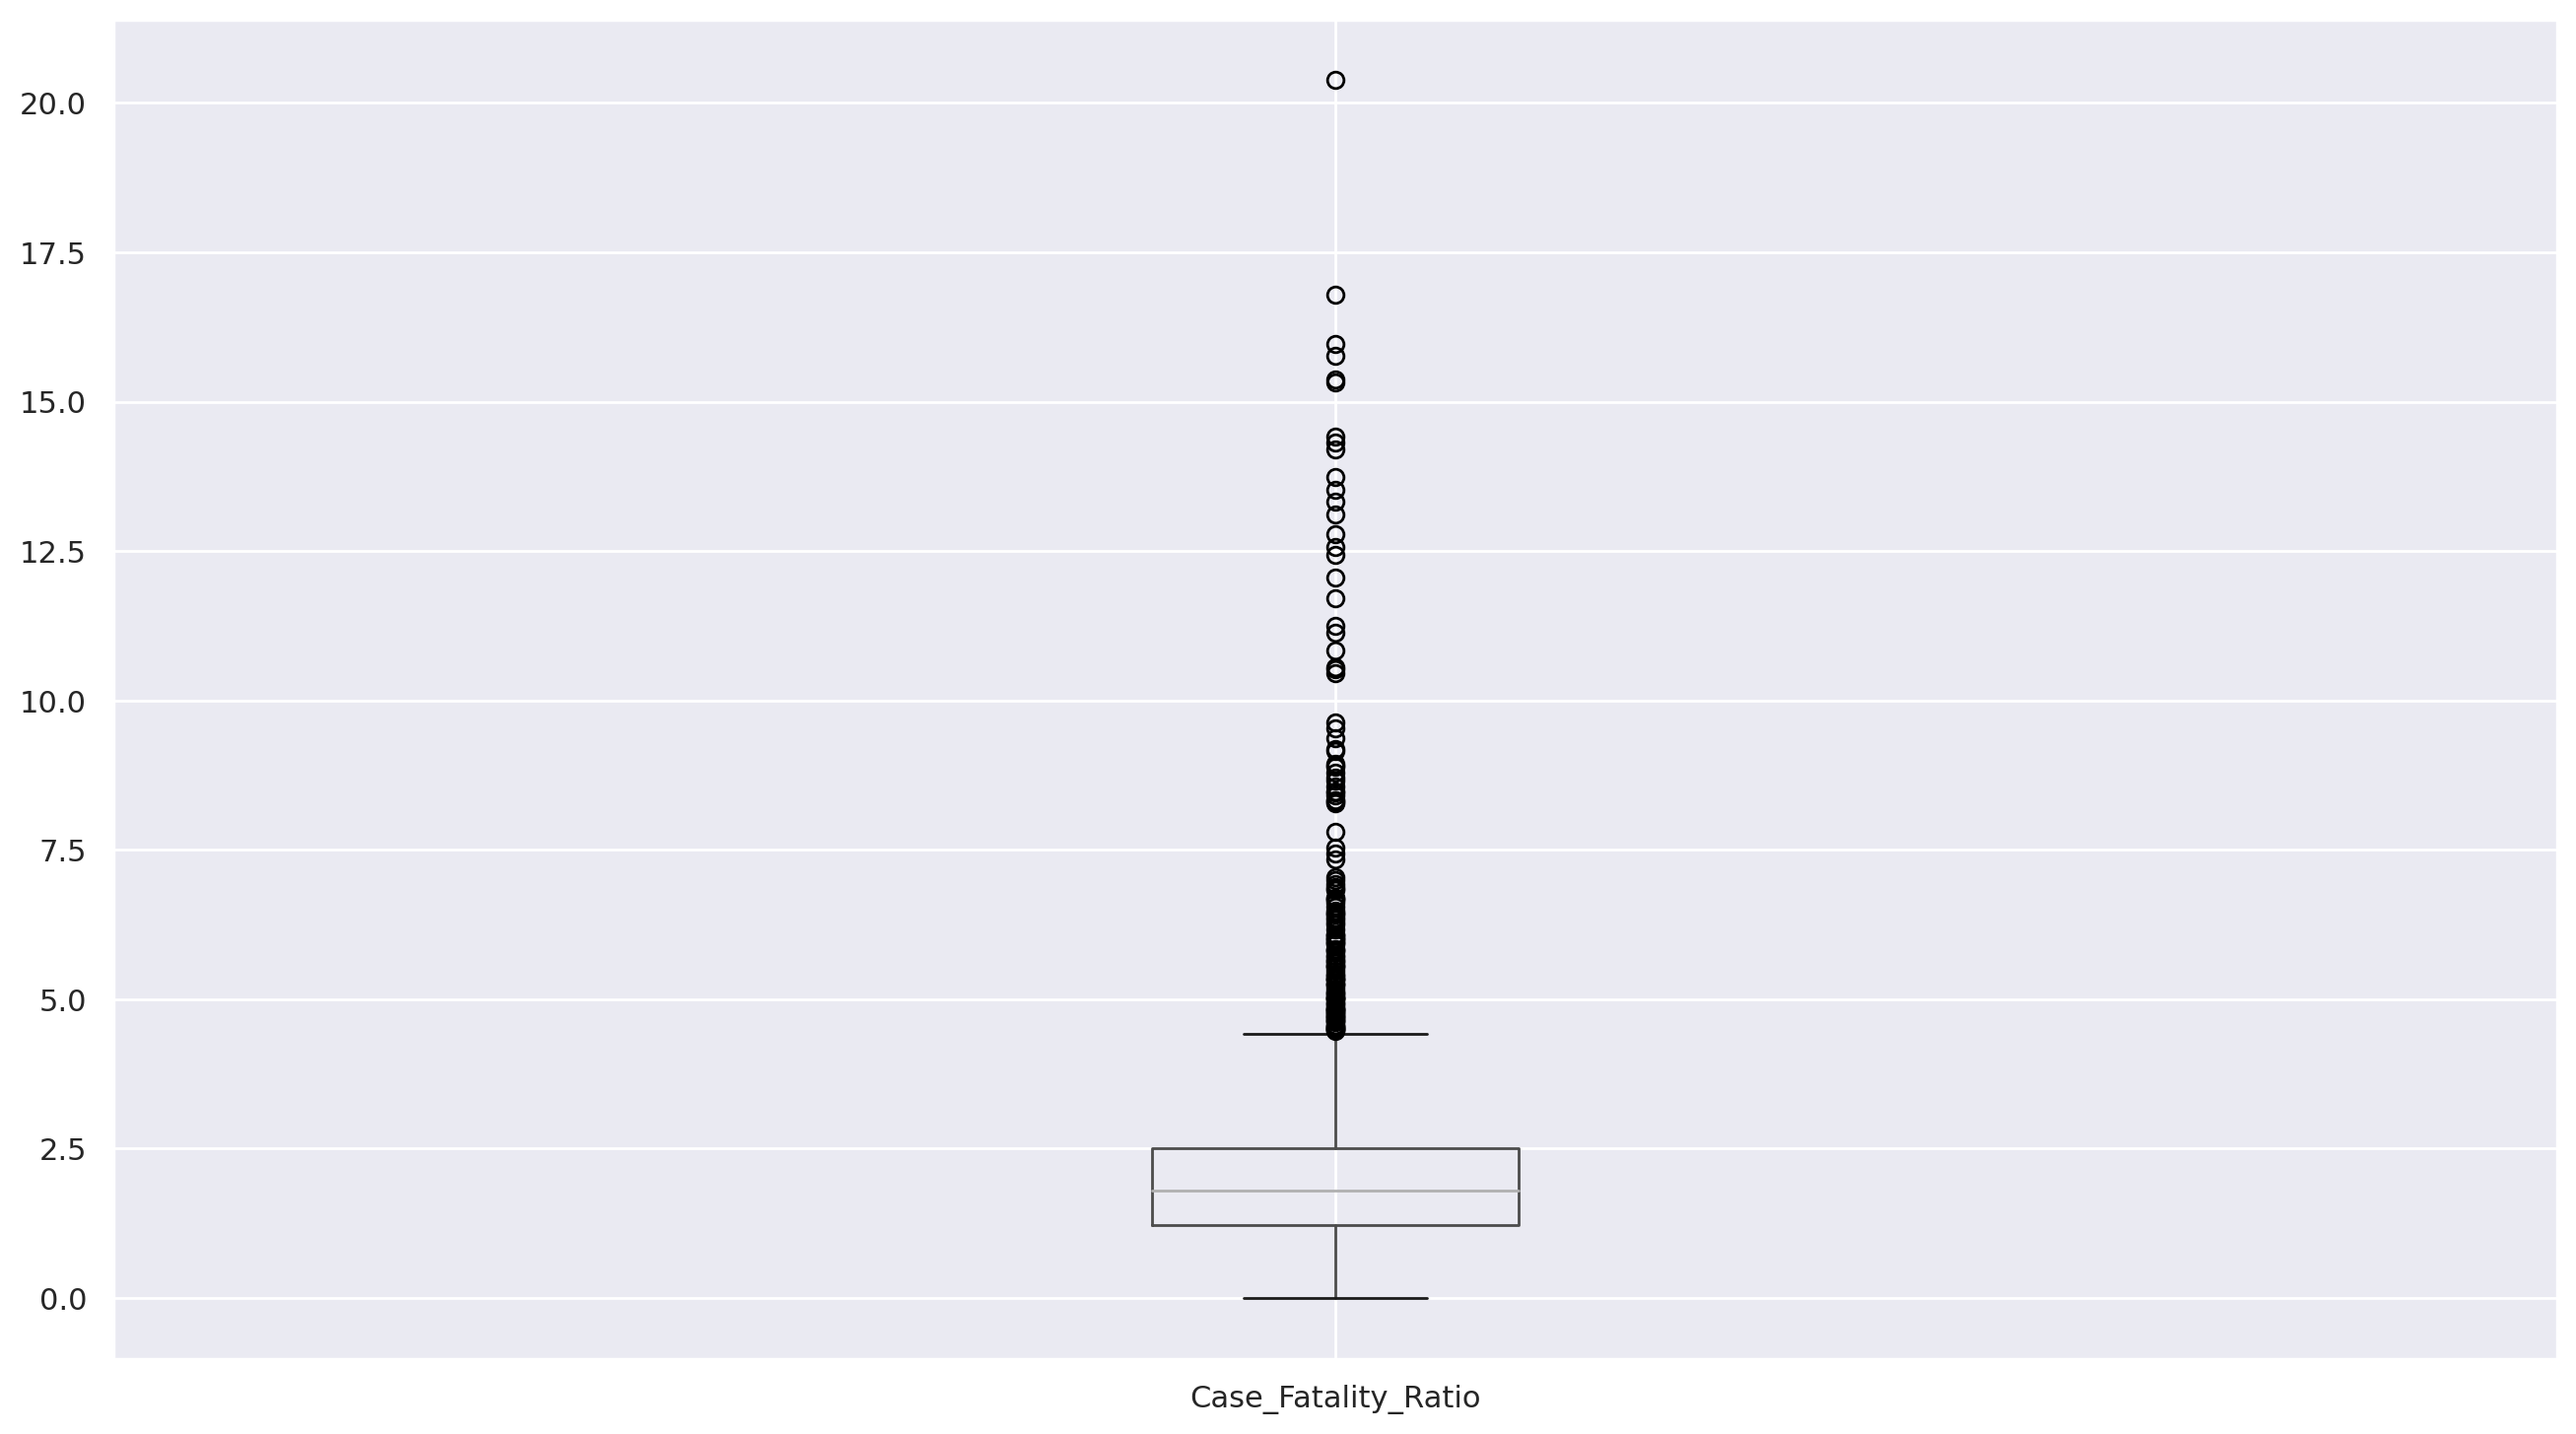

In [53]:
boxplot9 = location.boxplot(column=['Case_Fatality_Ratio'])

In [54]:
outlierColumns = location[['Case_Fatality_Ratio']]

In [55]:
filteredLocation = outlierColumns[(np.abs(stats.zscore(outlierColumns)) < 2).all(axis=1)]
# Reference: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe

In [56]:
location = pd.concat([location, filteredLocation], axis=1, join="inner")
location = location.loc[:,~location.columns.duplicated()]

## 1.6 Joining the cases and location dataset

In [57]:
location['Country_Region'] = location['Country_Region'].replace(['US'],'United States')
location['Country_Region'] = location['Country_Region'].replace(['Korea, South'],'South Korea')
location['Country_Region'] = location['Country_Region'].replace(['Taiwan*'],'Taiwan')

In [58]:
aggColumnsInLocation = location[['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered', 'Active']]
meanColumnsInLocation = location[['Province_State', 'Country_Region', 'Incident_Rate', 'Case_Fatality_Ratio']]

In [59]:
aggColumnsInLocation = aggColumnsInLocation.groupby(['Province_State', 'Country_Region']).sum()


In [60]:
meanColumnsInLocation = meanColumnsInLocation.groupby(['Province_State', 'Country_Region']).mean()


In [61]:
groupedLocation = pd.merge(aggColumnsInLocation, meanColumnsInLocation, on=['Province_State', 'Country_Region'], how='inner')
groupedLocation
groupedLocation.to_csv('../results/location_2021_processed.csv.csv')

In [62]:
joined_case_train = pd.merge(cases_train, groupedLocation,  how='left', left_on=['country','province'], right_on = ['Country_Region','Province_State'])
joined_case_test = pd.merge(cases_test, groupedLocation,  how='left', left_on=['country','province'], right_on = ['Country_Region','Province_State'])

In [63]:
joined_case_train

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome_group,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
0,40,female,Tamil Nadu,India,13.08362,80.28252,17.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
1,37,unknown,Tamil Nadu,India,12.68224,79.98008,04.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
2,40,unknown,Tamil Nadu,India,8.96350,77.30821,04.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
3,27,male,Tamil Nadu,India,13.08362,80.28252,13.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
4,54,male,Tamil Nadu,India,10.38486,78.79294,27.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23048,17,female,Tamil Nadu,India,13.08362,80.28252,20.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
23049,25,male,Bihar,India,25.73271,86.98845,30.05.2020,,https://twitter.com/BiharHealthDept/status/126...,False,hospitalized,265527.0,1576.0,262371.0,1580.0,212.762145,0.593537
23050,16,female,Tamil Nadu,India,13.08362,80.28252,18.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463
23051,52,male,Tamil Nadu,India,12.68224,79.98008,13.05.2020,,https://stopcorona.tn.gov.in/wp-content/upload...,False,hospitalized,886673.0,12719.0,858075.0,15879.0,1139.078325,1.434463


In [64]:
joined_case_test
joined_case_test.to_csv('../results/cases_2021_test_processed.csv')

In [65]:
joined_case_train = joined_case_train.dropna()
joined_case_test = joined_case_test.dropna()

In [66]:
joined_case_train
joined_case_train.to_csv('../results/cases_2021_train_processed.csv')

In [67]:
joined_case_test

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome_group,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
